In [1]:
import pandas as pd
df = pd.read_csv("/prj/Qingyang/psi_cov10.bed", sep='\t', low_memory=False)
print(df.shape)

(11823337, 11)


In [3]:
pip install pyfaidx biopython

  Using cached biopython-1.85-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyfaidx import Fasta
from Bio.Seq import Seq
from Bio import SeqIO

BED_FILE = "/prj/Qingyang/psi_cov10.bed"
GENOME_FILE = "/biodb/genomes/homo_sapiens/GRCh38_102/GRCh38_102.fa"
OUTPUT_BED = "psi_cov10_with_5mer.bed"
OUTPUT_CSV = "psi_cov10_with_5mer.csv"

In [16]:
print(df.head())

  chrom  chromStart  chromEnd   name  score strand  thickStart  thickEnd  \
0     1       14384     14385  17802     11      -       14384     14385   
1     1       14387     14388  17802     15      -       14387     14388   
2     1       14390     14391  17802     10      -       14390     14391   
3     1       14393     14394  17802     14      -       14393     14394   
4     1       14395     14396  17802     12      -       14395     14396   

   itemRgb  coverage  frequency  
0  255,0,0        11       9.09  
1  255,0,0        15       0.00  
2  255,0,0        10      30.00  
3  255,0,0        14       7.14  
4  255,0,0        12       0.00  


In [3]:
genome = Fasta(GENOME_FILE)
cols = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 
        'thickStart', 'thickEnd', 'itemRgb', 'coverage', 'frequency']
bed_df = pd.read_csv(BED_FILE, sep='\t', header=0, low_memory=False)
print(bed_df.head(5))
print(bed_df.columns)

  chrom  chromStart  chromEnd   name  score strand  thickStart  thickEnd  \
0     1       14384     14385  17802     11      -       14384     14385   
1     1       14387     14388  17802     15      -       14387     14388   
2     1       14390     14391  17802     10      -       14390     14391   
3     1       14393     14394  17802     14      -       14393     14394   
4     1       14395     14396  17802     12      -       14395     14396   

   itemRgb  coverage  frequency  
0  255,0,0        11       9.09  
1  255,0,0        15       0.00  
2  255,0,0        10      30.00  
3  255,0,0        14       7.14  
4  255,0,0        12       0.00  
Index(['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand',
       'thickStart', 'thickEnd', 'itemRgb', 'coverage', 'frequency'],
      dtype='object')


In [4]:
bed_df['chromStart'] = bed_df['chromStart'].astype(int)
bed_df['chromEnd'] = bed_df['chromEnd'].astype(int)

In [5]:
from pyfaidx import Fasta

def load_genome(genome_file):
    """Load reference genome"""
    genome = Fasta(genome_file)
    print("Reference genome loading completed")
    return genome

In [6]:
def extract_5mer_with_skipped(bed_df, genome, skipped_output='skipped_sites.csv'):
    """
    Extract 5mer sequences from BED tables, automatically process positive 
    and negative strands, and record skipped sites。
    
    Parameters:
    - bed_df: Read the BED data frame
    - genome: Reference genome (pyfaidx.Fasta loading object)
    - skipped_output: Skip record saving path (CSV format)
    
    Return:
    - five_mers: Extracted 5mer list (same order as bed_df)
    """
    print("[3] Extracting 5mer...")

    five_mers = []       
    skipped_sites = []   

    for idx, row in bed_df.iterrows():
        chrom = str(row['chrom']) 
        start = int(row['chromStart']) - 2 
        end = int(row['chromEnd']) + 2      
        strand = row['strand']
        name = row['name']

        if start < 0:
            start = 0

        try:
            seq = genome[chrom][start:end].seq.upper()
        except KeyError:
            print(f"[Warning] Chromosome {chrom} not found in reference genome, skipping {name}")
            skipped_sites.append({'name': name, 'chrom': chrom, 'start': start, 'end': end, 'strand': strand, 'reason': 'chrom not found'})
            five_mers.append('NA')
            continue

        if strand == '-':
            seq = str(Seq(seq).reverse_complement())

        if len(seq) != 5:
            print(f"[Warning] 5mer length of {name} is not 5 ({len(seq)} bp), skipping")
            skipped_sites.append({'name': name, 'chrom': chrom, 'start': start, 'end': end, 'strand': strand, 'reason': f'seq length {len(seq)}'})
            five_mers.append('NA')
            continue

        five_mers.append(seq)

    if skipped_sites:
        pd.DataFrame(skipped_sites).to_csv(skipped_output, index=False)
        print(f"[Tip] The skipped position has been saved to {skipped_output}")

    print("[Complete] 5mer extraction completed！")
    return five_mers

In [7]:
def save_results(bed_df, output_bed, output_csv):
    print("[4] Saving results...")
    
    bed_df.to_csv(output_bed, sep='\t', index=False, header=True, encoding='utf-8')
    print(f"[Done] BED file saved: {output_bed}\n")

In [8]:
def main():
    print("[1] Reading BED file...")
    bed_df = pd.read_csv(BED_FILE, sep='\t', header=0, low_memory=False)
    bed_df['chromStart'] = bed_df['chromStart'].astype(int)
    bed_df['chromEnd'] = bed_df['chromEnd'].astype(int)
    print(f"[Complete] Total {len(bed_df)} records")

    assert isinstance(bed_df, pd.DataFrame), f"[ERROR] After reading BED, bed_df is not a DataFrame, but {type(bed_df)}"

    print("[2] Loading reference genome...")
    genome = load_genome(GENOME_FILE)

    print("[3] Extracting 5mer...")
    five_mers = extract_5mer_with_skipped(bed_df, genome)  

    bed_df["5mer"] = five_mers

    assert isinstance(bed_df, pd.DataFrame), f"[ERROR] After 5mer extraction, bed_df is not a DataFrame but {type(bed_df)}"

    print("[4] Saving results...")
    save_results(bed_df, OUTPUT_BED, OUTPUT_CSV)
    print("[All completed]")

if __name__ == "__main__":
    main()

[1] Reading BED file...
[Complete] Total 11823337 records
[2] Loading reference genome...
Reference genome loading completed
[3] Extracting 5mer...
[3] Extracting 5mer...
[Warning] 5mer length of 17802 is not 5 (4 bp), skipping
[Warning] 5mer length of 17802 is not 5 (4 bp), skipping
[Tip] The skipped position has been saved to skipped_sites.csv
[Complete] 5mer extraction completed！
[4] Saving results...
[4] Saving results...
[Done] BED file saved: psi_cov10_with_5mer.bed

[All completed]


In [33]:
df = pd.read_csv("psi_cov10_with_5mer.bed", sep='\t', low_memory=False)
print(df.shape)

(11823337, 12)


In [34]:
print(df.head())

  chrom  chromStart  chromEnd   name  score strand  thickStart  thickEnd  \
0     1       14384     14385  17802     11      -       14384     14385   
1     1       14387     14388  17802     15      -       14387     14388   
2     1       14390     14391  17802     10      -       14390     14391   
3     1       14393     14394  17802     14      -       14393     14394   
4     1       14395     14396  17802     12      -       14395     14396   

   itemRgb  coverage  frequency   5mer  
0  255,0,0        11       9.09  AATAA  
1  255,0,0        15       0.00  TTTAA  
2  255,0,0        10      30.00  GCTTT  
3  255,0,0        14       7.14  TGTGC  
4  255,0,0        12       0.00  AGTGT  


In [10]:
import pandas as pd
df = pd.read_csv("psi_cov10_with_5mer.bed", sep='\t', low_memory=False)
print(df.shape)

(11823337, 12)


In [3]:
print(df.head())

  chrom  chromStart  chromEnd   name  score strand  thickStart  thickEnd  \
0     1       14384     14385  17802     11      -       14384     14385   
1     1       14387     14388  17802     15      -       14387     14388   
2     1       14390     14391  17802     10      -       14390     14391   
3     1       14393     14394  17802     14      -       14393     14394   
4     1       14395     14396  17802     12      -       14395     14396   

   itemRgb  coverage  frequency   5mer  
0  255,0,0        11       9.09  AATAA  
1  255,0,0        15       0.00  TTTAA  
2  255,0,0        10      30.00  GCTTT  
3  255,0,0        14       7.14  TGTGC  
4  255,0,0        12       0.00  AGTGT  


In [11]:
import logomaker
import matplotlib.pyplot as plt
sequences = df["5mer"]

In [14]:
import pandas as pd

cleaned_sequences = []
invalid_count = 0

for seq in sequences:
    if isinstance(seq, str):
        cleaned_sequences.append(seq)
    else:
        invalid_count += 1
        cleaned_sequences.append('NNNNN')  

print(f"Found {invalid_count} illegal sequences, replaced with 'N'.")

filtered_sequences = [seq for seq in cleaned_sequences if 'N' not in seq]

print("After filtering, {len(filtered_sequences)} legal sequences remain for drawing.")

Found 2 illegal sequences, replaced with 'N'.
After filtering, {len(filtered_sequences)} legal sequences remain for drawing.


In [9]:
info_matrix = logomaker.alignment_to_matrix(filtered_sequences, to_type="information")

<Figure size 1000x400 with 0 Axes>

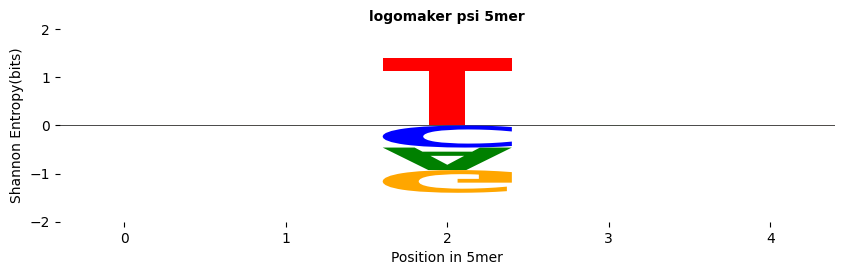

In [10]:
plt.figure(figsize=(10, 4))
logo = logomaker.Logo(info_matrix, center_values=True, width=0.8)
logo.ax.set_ylabel("Information Content (bits)")
logo.ax.set_ylabel("Shannon Entropy(bits)")
logo.ax.set_xlabel("Position in 5mer")
logo.ax.set_title("logomaker psi 5mer", fontsize=10, fontweight='bold')
logo.ax.set_xticks(range(len(info_matrix)))
logo.ax.set_xticklabels(range(1, len(info_matrix) + 1))
logo.ax.set_ylim([-2, 2])
logo.style_spines(visible=False)
logo.style_xticks(rotation=0, fmt="%d", anchor=0)
logo.style_glyphs(fade_below=0.2)

In [11]:
counts_matrix = logomaker.alignment_to_matrix(filtered_sequences)
print(counts_matrix.head)

<bound method NDFrame.head of            A        C        G         T
pos                                     
0    2986943  2596335  2556338   3683716
1    2739868  3202093  2359873   3521498
2      38346    90495     9273  11685218
3    2197232  2604652  3522390   3499058
4    2970174  2744826  2404045   3704287>


In [12]:
info_matrix = logomaker.alignment_to_matrix(filtered_sequences, to_type='information')

Text(0.5, 1.0, '5mer m6A')

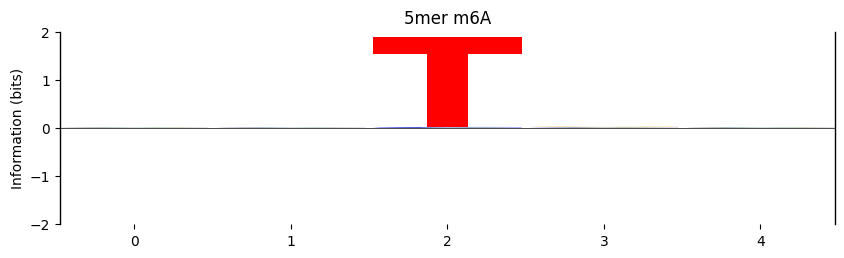

In [13]:
logo = logomaker.Logo(info_matrix, color_scheme="classic")
logo.style_spines(visible=False)
logo.style_spines(spines = ["left", "right"], visible=True)
logo.ax.set_ylabel("Information (bits)")
logo.ax.set_ylim([-2, 2])
plt.title('5mer m6A')

Text(0.5, 1.0, '5mer psi')

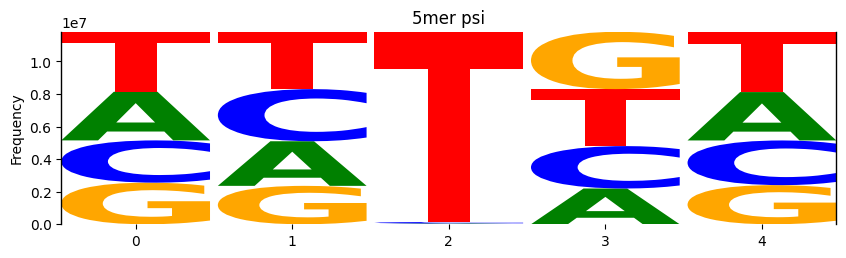

In [14]:
logo = logomaker.Logo(counts_matrix, color_scheme="classic")
logo.style_spines(visible=False)
logo.style_spines(spines = ["left", "right"], visible=True)
logo.ax.set_ylabel("Frequency")
plt.title('5mer psi')

/home/qyang/.venvs/jupyter_practical/lib/python3.11/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'N' is not in color_dict. Using black.
  warnings.warn(str(Error))


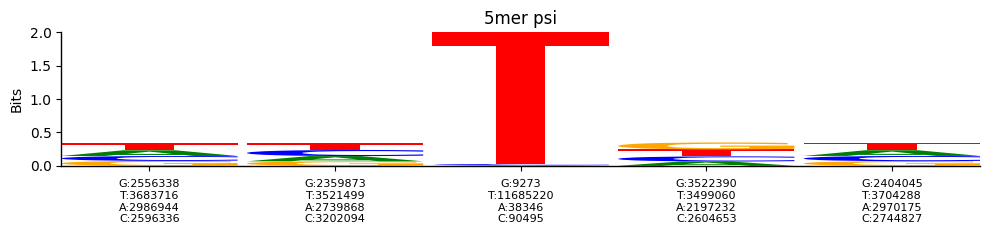

In [16]:
import pandas as pd
import logomaker
import matplotlib.pyplot as plt
import numpy as np

five_mers = df['5mer'].dropna().tolist()
info_matrix = logomaker.alignment_to_matrix(sequences=five_mers, to_type='information')

logo = logomaker.Logo(info_matrix, color_scheme='classic')

logo.ax.set_ylabel("Bits")
logo.ax.set_ylim([0, 2])

logo.ax.set_xticks([0, 1, 2, 3, 4])
logo.ax.set_xticklabels(['1', '2', '3', '4', '5'])
logo.ax.set_xticklabels([])

logo.style_spines(visible=False)
logo.style_spines(spines=["left", "bottom"], visible=True)

counts_matrix = logomaker.alignment_to_matrix(sequences=five_mers, to_type='counts')

for pos in range(5):
    g_count = counts_matrix.loc[pos, 'G'] if 'G' in counts_matrix.columns else 0
    t_count = counts_matrix.loc[pos, 'T'] if 'T' in counts_matrix.columns else 0
    a_count = counts_matrix.loc[pos, 'A'] if 'A' in counts_matrix.columns else 0
    c_count = counts_matrix.loc[pos, 'C'] if 'C' in counts_matrix.columns else 0
    text = f"G:{g_count}\nT:{t_count}\nA:{a_count}\nC:{c_count}"
    logo.ax.text(pos, -0.2, text, ha='center', va='top', fontsize=8, transform=logo.ax.transData)

plt.title("5mer psi")

plt.tight_layout()
plt.show()